**grover search**

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def int2bit( n, k ):
    assert n < 2 ** k
    b = [ 0 if b == '0' else 1 for b in bin( n )[ 2 : ] ]
    b = ( k - len( b ) ) * [ 0 ] + b
    return b # the binary expansion of n, as a list of k bits

In [3]:
def bit2int( b ):
    n = sum( [ bn * 2 ** n for n, bn in enumerate( reversed( b ) ) ] )
    return n

In [4]:
def reflection( q ):
    return [ cirq.Z.controlled( len( q ) - 1 ).on( * q[ : -1 ], q[ -1 ] ) ]

In [5]:
def oracle_block( q, m ): # only the oracle knows m
    b = int2bit( m, len( q ) ) # the bits of m
    Xs = [ cirq.X( qn ) for qn, bn in zip( q, b ) if bn == 0 ]
    R = reflection( q )
    return Xs + R + Xs # list of gates

In [6]:
def diffusion_block( q ):
    Hs = [ cirq.H( qn ) for qn in q ]
    Xs = [ cirq.X( qn ) for qn in q ]
    R = reflection( q )
    return Hs + Xs + R + Xs + Hs # list of gates

In [7]:
def grover_block( q, oracle ):
    diffuser = diffusion_block( q )
    return oracle + diffuser # list of gates

In [8]:
def grover_circuit( q, oracle ):
    iterations = len( q ) // 2
    Hs = [ cirq.H( qn ) for qn in q ]
    blocks = iterations * grover_block( q, oracle )
    measure = [ cirq.measure( qn, key = str( n ) ) for n, qn in enumerate( q ) ]
    circuit = cirq.Circuit( Hs + blocks + measure )
    return circuit

In [9]:
def simulate( q, program, repetitions ):
    k = len( q )
    result = cirq.Simulator( ).run( program = program, repetitions = repetitions )
    result = np.array( [ result.measurements[ str( n ) ] for n in range( k ) ] ).squeeze( )
    measurement = np.array( [ bit2int( result[ : , n ] ) for n in range( repetitions ) ] )
    frequency = np.zeros( 2 ** k )
    for n in measurement:
        frequency[ n ] = frequency[ n ] + 1
    sim = { 'result' : result, 'measurement' : measurement, 'frequency' : frequency }
    return sim

In [10]:
def display( q, circuit, sim ):
    fig, axis = plt.subplots( )
    axis.set_xlabel( 'measurement', color = 'white', size = '14' )
    axis.set_ylabel( 'frequency',   color = 'white', size = '14' )
    axis.set_facecolor( 'black' )
    axis.tick_params( colors = 'white' )
    axis.plot( range( 2 ** len( q ) ), sim [ 'frequency' ], color = 'white' )
    plt.show( )
    print( f'measurements\n{ sim[ "measurement" ] }' )
    if len( q ) < 6:
        print( f'\ncircuit\n{ circuit }\n' )

In [14]:
m = 6 # sought after number
k = 5 # number of qubits
q = cirq.LineQubit.range( k )
oracle = oracle_block( q, m )
grover = grover_circuit( q, oracle )

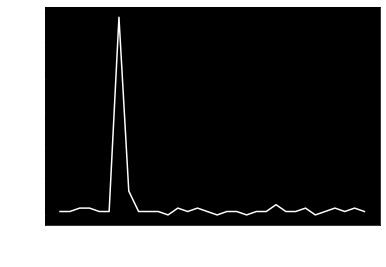

measurements
[ 2  6 23  6  6  3  2  6  6 10 31 13  6 14  6  1  6  6 27  6  7  6  6  6
  6  4  6 30 28  6  6 15  6 12  5 22  6  6  6  6 30 22 28 22  3 25  6  6
  6  7  7  6  6  6 24  6  6  7  6  6  6  8  6  0  6  7  6 21  6  9 29  6
 18  6  6 12  6  7  6  6  6  6  6  6  6  6  6 17  6  6 20 14  6  6  6  6
 25  6  6  7]

circuit
0: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('0')───
              │               │               │               │
1: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('1')───
              │               │               │               │
2: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('2')───
              │               │               │               │
3: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('3')───
              │               │               │               │
4: ───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───M('4')

In [15]:
repetitions = 100
simulation = simulate( q, grover, repetitions )
display( q, grover, simulation )